#### Agentic orchestrator

We use this design pattern when we typically don't know the subtask to perform and we delegate the picking of the sub-tasks from a set of tasks to the orchestrator, who can spawn a series of workers (or a single worker) to do the job. In other words, this can do complicated stuff like orchestrating a mini work flow itself based on some criterion.

In this use case, we will write individual sections of a report with each section written by LLM. Note that writing each section in itself is a mini workflow and is not a simple parallel task but depends on what has been written before etc.


In [1]:
import os
from langchain_community.llms import Ollama
from langchain.agents import initialize_agent, AgentType
from typing import Literal, Annotated, Literal, Optional, TypedDict
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import END, START, MessagesState, StateGraph
from langchain_core.tools import tool as tool

import asyncio
import operator
from langgraph.graph import END, START, StateGraph
from langgraph.types import Send
from pydantic import BaseModel, Field

In [2]:
load_dotenv("../.env")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY_PERSONAL")

In [3]:
model = ChatOpenAI(model="gpt-4.1-mini", temperature=0)

In [4]:
class Section(BaseModel):
    name: str = Field(description="The name of the section")
    description: str = Field(description="The description of the section")


class CompletedSection(BaseModel):
    name: str = Field(description="The name of the section")
    content: str = Field(description="The content of the section")


class Sections(BaseModel):
    sections: list[Section] = Field(description="The sections of the article")


class OrchestratorState(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list[CompletedSection], operator.add]
    final_report: str


class WorkerState(TypedDict):
    section: str
    completed_sections: Annotated[list[Section], operator.add]

In [5]:
def orchestrator(state: OrchestratorState) -> dict:
    model_planner = model.with_structured_output(Sections)
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic, you will generate the sections for a short article."
        ),
        HumanMessage(
            content=f"Generate the sections of an article about {state['topic']}"
        ),
    ]
    return {"sections": model_planner.invoke(messages).sections}


def write_section(state: WorkerState) -> str:
    messages = [
        SystemMessage(
            content="You are an expert writer specialized in SEO. Provided with a topic and a table of contents, you will generate the content of the article."
        ),
        HumanMessage(
            content=f"Generate the content of an article about {state['section'].name} with the following description: {state['section'].description}"
        ),
    ]
    section = CompletedSection(
        name=state['section'].name, content=model.invoke(messages).content
    )
    return {"completed_sections": [section]}


def synthesizer(state: OrchestratorState) -> str:
    ordered_sections = state["completed_sections"]
    completed_sections_str = "\n\n".join(
        [section.content for section in ordered_sections]
    )
    return {"final_report": completed_sections_str}

# Send is a list of Sends. this probably makes the whole flow parallel with each worker taking up a list element ?
def assign_workers(state: OrchestratorState) -> dict:
    return [
        Send("write_section", {"section": section}) for section in state["sections"]
    ]

In [8]:
workflow_builder = StateGraph(OrchestratorState)

workflow_builder.add_node("orchestrator", orchestrator)
workflow_builder.add_node("write_section", write_section)
workflow_builder.add_node("synthesizer", synthesizer)

workflow_builder.add_edge(START, "orchestrator")
workflow_builder.add_conditional_edges(source="orchestrator", 
                                       path=assign_workers, 
                                       path_map=["write_section"])
workflow_builder.add_edge("write_section", "synthesizer")
workflow_builder.add_edge("synthesizer", END)

workflow = workflow_builder.compile()


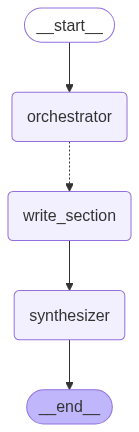

In [9]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [10]:
workflow.invoke({"topic": "Types of qubits"})

{'topic': 'Types of qubits',
 'sections': [Section(name='Introduction to Qubits', description='An overview of what qubits are and their role in quantum computing.'),
  Section(name='Superconducting Qubits', description='Explanation of superconducting qubits, how they work, and their applications.'),
  Section(name='Trapped Ion Qubits', description='Details about trapped ion qubits, their mechanism, and advantages.'),
  Section(name='Topological Qubits', description='Insight into topological qubits and their potential for error resistance.'),
  Section(name='Photonic Qubits', description='Description of photonic qubits and their use in quantum communication.'),
  Section(name='Spin Qubits', description='Information on spin qubits based on electron or nuclear spins in semiconductors.'),
  Section(name='Comparison of Qubit Types', description='A comparative analysis of different qubit types in terms of coherence time, scalability, and error rates.'),
  Section(name='Future Directions in Q